### Creating dummy variables

In [1]:
import pandas as pd

music_df = pd.read_csv('../01_Supervised_Learning/Data/music_clean.csv')

# Create music_dummies
music_dummies = pd.get_dummies(music_df, drop_first=True)

# Print the new DataFrame's shape
print("Shape of music_dummies: {}".format(music_dummies.shape))


Shape of music_dummies: (1000, 13)


### Regression with categorical features

In [2]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Create X and y
X = music_dummies.drop(['popularity'], axis=1).values
y = music_dummies['popularity'].values

# Cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate a ridge model
ridge = Ridge(alpha=0.2)

# Perform cross-validation
scores = cross_val_score(ridge, X, y, cv=kf, scoring="neg_mean_squared_error")

# Calculate RMSE
rmse = np.sqrt(-scores)
print("Average RMSE: {}".format(np.mean(rmse)))
print("Standard Deviation of the target array: {}".format(np.std(y)))

Average RMSE: 10.033098690539362
Standard Deviation of the target array: 14.02156909907019


### Dropping missing data

In [3]:
# Print missing values for each column
print(music_df.isna().sum().sort_values())

Unnamed: 0          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
genre               0
dtype: int64


### Pipeline for song genre prediction: I

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# Instantiate an imputer
imputer = SimpleImputer(strategy="most_frequent")

# Instantiate a knn model
knn = KNeighborsClassifier(n_neighbors=3)

# Build steps for the pipeline
steps = [("imputer", imputer), 
         ("knn", knn)]

### Pipeline for song genre prediction: II

In [5]:
# Define imp_mean explicitly
imp_mean = SimpleImputer(strategy="most_frequent")

from sklearn.model_selection import train_test_split

# Define target and feature for classification
X = music_dummies.drop(['genre'], axis=1).values
y = music_dummies['genre'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

steps = [("imputer", imp_mean),
        ("knn", knn)]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[92 12]
 [ 0 96]]


### Centering and scaling for regression

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# Define target and features again for regression
X = music_dummies.drop(['popularity'], axis=1).values
y = music_dummies['popularity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Create pipeline steps
steps = [("scaler", StandardScaler()),
         ("lasso", Lasso(alpha=0.5))]

# Instantiate the pipeline
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

# Calculate and print R-squared
print(pipeline.score(X_test, y_test))

0.49205337210745226


### Centering and scaling for classification

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Build the steps
steps = [   
            ("scaler", StandardScaler()),
            ("logreg", LogisticRegression(solver="liblinear"))
         ]
pipeline = Pipeline(steps)

# Create the parameter space
parameters = {"logreg__C": np.linspace(0.001, 1.0, 20)}

# X and y already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=21)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training data
cv.fit(X_train, y_train)
print(cv.best_score_, "\n", cv.best_params_)


d:\Projects_Repo\ml-scientist-datacamp-journey\ml-scientist-track-python\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


0.05750000000000001 
 {'logreg__C': 0.05357894736842105}


### Visualizing regression model performance

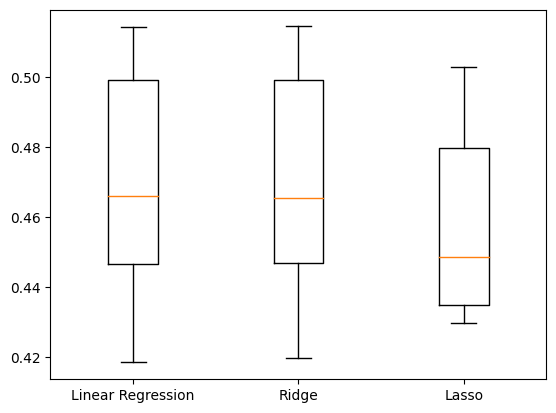

In [9]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

models = {
            "Linear Regression": LinearRegression(), 
            "Ridge": Ridge(alpha=0.1), 
            "Lasso": Lasso(alpha=0.1)
            }
results = []

# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=42, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.show()

### Predicting on the test set

In [10]:
# Import root_mean_squared_error
from sklearn.metrics import mean_squared_error

# Standardize the data for fair comparison
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for name, model in models.items():
  
  # Fit the model to the training data
  model.fit(X_train_scaled, y_train)
  
  # Make predictions on the test set
  y_pred = model.predict(X_test_scaled)
  
  # Calculate the test_rmse
  test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  print("{} Test Set RMSE: {}".format(name, test_rmse))

Linear Regression Test Set RMSE: 9.636622914208635
Ridge Test Set RMSE: 9.636710374153129
Lasso Test Set RMSE: 9.659087519106984


### Visualizing classification model performance

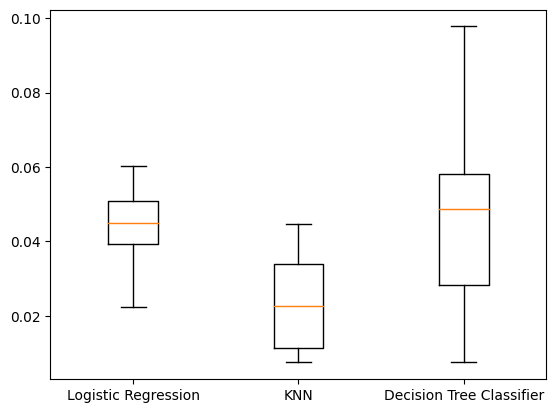

In [11]:
from sklearn.tree import DecisionTreeClassifier

models = {"Logistic Regression": LogisticRegression(solver='liblinear'), 
          "KNN": KNeighborsClassifier(),
          "Decision Tree Classifier": DecisionTreeClassifier()}
results = []

# Loop through the models' values
for model in models.values():
  
  # Instantiate a KFold object
  kf = KFold(n_splits=6, random_state=12, shuffle=True)
  
  # Perform cross-validation
  cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
  results.append(cv_results)

plt.boxplot(results, labels=models.keys())
plt.show()


### Pipeline for predicting song popularity

In [12]:
steps = [("imp_mean", SimpleImputer()), 
         ("scaler", StandardScaler()), 
         ("logreg", LogisticRegression(solver='liblinear'))]

# Set up pipeline
pipeline = Pipeline(steps)
params = {"logreg__solver": ["newton-cg", "saga", "lbfgs"],
         "logreg__C": np.linspace(0.001, 1.0, 10)}

# Create the GridSearchCV object
tuning = GridSearchCV(pipeline, param_grid=params)
tuning.fit(X_train, y_train)
y_pred = tuning.predict(X_test)

# Compute and print performance
print("Tuned Logistic Regression Parameters: {}, Accuracy: {}".format(tuning.best_params_, tuning.score(X_test, y_test)))

d:\Projects_Repo\ml-scientist-datacamp-journey\ml-scientist-track-python\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
d:\Projects_Repo\ml-scientist-datacamp-journey\ml-scientist-track-python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Projects_Repo\ml-scientist-datacamp-journey\ml-scientist-track-python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Projects_Repo\ml-scientist-datacamp-journey\ml-scientist-track-python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Projects_Repo\ml-scientist-datacamp-journey\ml-scientist-track-python\lib\sit

Tuned Logistic Regression Parameters: {'logreg__C': 0.667, 'logreg__solver': 'newton-cg'}, Accuracy: 0.04
